Corinne McCumber\
Professor Andrew Uhe\
IS445 Data Visualization\
1 May 2024
# Final Project: General Public View

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
import numpy as np
from wordcloud import WordCloud, STOPWORDS

## 1) Dataset Information and Licensing

### Dataset name:
Track metadata from the Free Music Archive (FMA)
### Found via: 
Library of Congress https://lccn.loc.gov/2018655052
### Downloaded from: 
https://github.com/mdeff/fma \
Direct zip file download for all metadata (only tracks.csv and genres.csv are used here): https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
### License: 
Creative Commons Attribution 4.0 International License (CC BY 4.0, https://creativecommons.org/licenses/by/4.0/), which allows for sharing and adaptation so long as appropriate attribution is given.
### File size, items, description:
Tracks.csv is 254.311 MB. It contains metadata for album, artist, and specific track for the 106,574 tracks in the full FMA dataset (e.g. album date released, album listens, artist bio, artist latitude and longitude, track bit rate, track title, track genre, track listens, etc.). As such, this is a mix of integer, string, and date values. Since metadata is not complete for all tracks contained in the set, I will generally be examining metadata categories that are present for at least 95% of the dataset, discarding those tracks where metadata was not provided. One exception to this is the artist latitude and longitude data, which are only present for 23% of the tracks, but which I will be using in order to have fun with maps.

### Suggested Citation:
@inproceedings{fma_dataset, \
  title = {{FMA}: A Dataset for Music Analysis}, \
  author = {Defferrard, Michaël and Benzi, Kirell and Vandergheynst, Pierre and Bresson, Xavier}, \
  booktitle = {18th International Society for Music Information Retrieval Conference (ISMIR)}, \
  year = {2017}, \
  archiveprefix = {arXiv}, \
  eprint = {1612.01840}, \
  url = \{https://arxiv.org/abs/1612.01840 \}, \
}

### Additional geography dataset:
#### Dataset name:
Nautral Earth 1:110m Cultural Vectors, Admin 0 - Countries
#### Found via:
GeoPandas documentation
#### Downloaded from:
https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
#### License:
Public domain. Maps may be used in any manner, no permission is needed and crediting authors is not necessary. Shout out to Tom Patterson and Nathaniel Vaughn Kelso, though! \
https://www.naturalearthdata.com/about/terms-of-use/ \
https://creativecommons.org/public-domain/
#### File size, items, description:
The file in total is 210.08 KB, and it contains geographical data (polygons to be deciphered by GeoPandas) for the 258 countries in the world.

## 2) Reading in and Cleaning the Dataset

In [2]:
# Display all columns for easier troubleshooting
pd.set_option('display.max_columns', None) 

df = pd.read_csv(r'data/tracks.csv', parse_dates=True, header=[0,1,2], encoding ='utf-8')

# Combine three header rows into one row to avoid MultiIndex issues. 
# Variable k is just the 'track_id' header for column 0 listed in its own separate row, which is reinstated with df.rename.
df.columns = [f'{i}_{j}' for i,j,k in df.columns] 
df.rename(columns={'Unnamed: 0_level_0_Unnamed: 0_level_1': 'track_id'}, inplace=True) 

df.shape

(106574, 53)

In [3]:
df.head()

track_id  album_comments   album_date_created  album_date_released  \
0         2               0  2008-11-26 01:44:45  2009-01-05 00:00:00   
1         3               0  2008-11-26 01:44:45  2009-01-05 00:00:00   
2         5               0  2008-11-26 01:44:45  2009-01-05 00:00:00   
3        10               0  2008-11-26 01:45:08  2008-02-06 00:00:00   
4        20               0  2008-11-26 01:45:05  2009-01-06 00:00:00   

  album_engineer  album_favorites  album_id  \
0            NaN                4         1   
1            NaN                4         1   
2            NaN                4         1   
3            NaN                4         6   
4            NaN                2         4   

                           album_information  album_listens album_producer  \
0                                    <p></p>           6073            NaN   
1                                    <p></p>           6073            NaN   
2                                    <p></p>           6073            NaN   
3                                        NaN          47632            NaN   
4  <p> "spiritual songs" from Nicky Cook</p>           2710            NaN   

  album_tags           album_title  album_tracks album_type  \
0         []  AWOL - A Way Of Life             7      Album   
1         []  AWOL - A Way Of Life             7      Album   
2         []  AWOL - A Way Of Life             7      Album   
3         []     Constant Hitmaker             2      Album   
4         []                 Niris            13      Album   

  artist_active_year_begin artist_active_year_end  \
0      2006-01-01 00:00:00                    NaN   
1      2006-01-01 00:00:00                    NaN   
2      2006-01-01 00:00:00                    NaN   
3                      NaN                    NaN   
4      1990-01-01 00:00:00    2011-01-01 00:00:00   

                            artist_associated_labels  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Mexican Summer, Richie Records, Woodsist, Skul...   
4                                                NaN   

                                          artist_bio  artist_comments  \
0  <p>A Way Of Life, A Collective of Hip-Hop from...                0   
1  <p>A Way Of Life, A Collective of Hip-Hop from...                0   
2  <p>A Way Of Life, A Collective of Hip-Hop from...                0   
3  <p><span style="font-family:Verdana, Geneva, A...                3   
4  <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...                2   

   artist_date_created  artist_favorites  artist_id  artist_latitude  \
0  2008-11-26 01:42:32                 9          1        40.058324   
1  2008-11-26 01:42:32                 9          1        40.058324   
2  2008-11-26 01:42:32                 9          1        40.058324   
3  2008-11-26 01:42:55                74          6              NaN   
4  2008-11-26 01:42:52                10          4        51.895927   

      artist_location  artist_longitude  \
0          New Jersey        -74.405661   
1          New Jersey        -74.405661   
2          New Jersey        -74.405661   
3                 NaN               NaN   
4  Colchester England          0.891874   

                                      artist_members artist_name  \
0  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...        AWOL   
1  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...        AWOL   
2  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...        AWOL   
3                           Kurt Vile, the Violators   Kurt Vile   
4                                       Nicky Cook\n  Nicky Cook   

                             artist_related_projects  \
0  The list of past projects is 2 long but every1...   
1  The list of past projects is 2 long but every1...   
2  The list of past projects is 2 long but every1...   
3            

In [4]:
df['album_date_created'].dtypes

dtype('O')

In [5]:
# The dates aren't being read in correctly. 'album_date_created' should be datetime, not an object/text.
date_columns = ['album_date_created', 'album_date_released', 'artist_active_year_begin', 'artist_active_year_end', 'artist_date_created',
                'track_date_created', 'track_date_recorded']

for column_name in date_columns:
    df[column_name] = pd.to_datetime(df[column_name])

In [6]:
df.dtypes

track_id                             int64
album_comments                       int64
album_date_created          datetime64[ns]
album_date_released         datetime64[ns]
album_engineer                      object
album_favorites                      int64
album_id                             int64
album_information                   object
album_listens                        int64
album_producer                      object
album_tags                          object
album_title                         object
album_tracks                         int64
album_type                          object
artist_active_year_begin    datetime64[ns]
artist_active_year_end      datetime64[ns]
artist_associated_labels            object
artist_bio                          object
artist_comments                      int64
artist_date_created         datetime64[ns]
artist_favorites                     int64
artist_id                            int64
artist_latitude                    float64
artist_loca

In [7]:
# To compare the most common words in track title, album title, and artist name, I'll need to make those columns all lowercase.
names_columns = ['album_title', 'artist_name', 'track_title']

for column in names_columns:
    df[column] = df[column].str.lower()

In [8]:
df['track_title'].head()

0               food
1       electric ave
2         this world
3            freeway
4    spiritual level
Name: track_title, dtype: object

## 3) Visualization: Artist Latitude and Longitude
Where are artists located worldwide? Of note, this information is only available for 23% of the dataset, so it is not necessarily representative.

In [9]:
# Dropping repeat artists, looking for 16,341 artists total.
location_df = df.loc[:, ['artist_id', 'artist_latitude', 'artist_longitude']]
location_df.drop_duplicates(subset='artist_id', keep='first', inplace=True)
location_df.shape

(16341, 3)

In [10]:
# artist_latitude and artist_longitude are only available for 23% of the artist dataset. Dropping NaN values, expecting output of ~3,758.
location_df.dropna(inplace=True)
location_df.shape

(3836, 3)

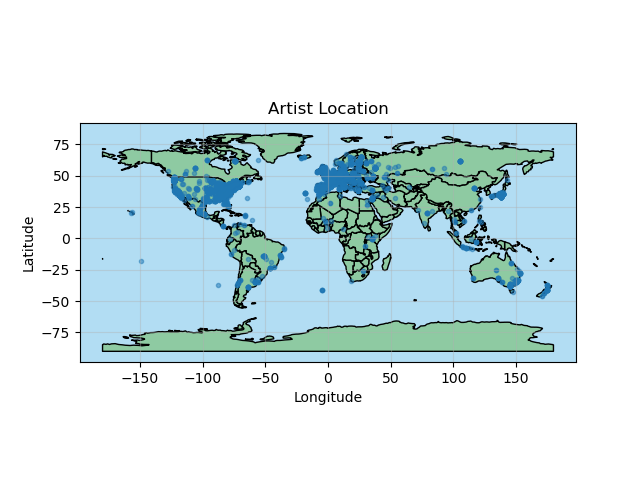

In [11]:
fig1, ax1 = plt.subplots()

countries = gpd.read_file(r'data\ne_110m_admin_0_countries.shp')
countries.plot(color='#8ECAA2',
               edgecolor='#000000',
               ax=ax1)

ax1.scatter(location_df['artist_longitude'], 
           location_df['artist_latitude'],
            marker = '.',
            alpha = 0.5)
plt.title('Artist Location')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_facecolor('#B2DDF3')
ax1.grid(alpha=0.4)

plt.show()

The sidebar options can be used to pan and zoom. There is greater representation in Europe and the US than in other parts of the world. Also, some location data seems to be entered in bad faith, for instance when it is in the middle of the Pacific Ocean.

## 4) Visualization: Most Common Words in Track Title for All Genres
What words are most common across a single genre when naming songs? Of note, tracks tagged with multiple or no genres are put into the 'Unclassified' category.

In [12]:
track_df = df.loc[:, ['track_id', 'track_title', 'track_genre_top']]
# Track_id and track_title are both available for 100% of the dataset, 
# track_genre_top, where only one strong genre was identified, is only available for 47%. Replacing NaN for use later.
track_df.replace(to_replace={'track_genre_top': np.nan}, value='Unclassified', inplace=True)
track_df


track_id                                track_title track_genre_top
0              2                                       food         Hip-Hop
1              3                               electric ave         Hip-Hop
2              5                                 this world         Hip-Hop
3             10                                    freeway             Pop
4             20                            spiritual level    Unclassified
...          ...                                        ...             ...
106569    155316                                  the auger            Rock
106570    155317                            let's skin ruby            Rock
106571    155318         my house smells like kim deal/pulp            Rock
106572    155319                    the man with two mouths            Rock
106573    155320  another trick up my sleeve (instrumental)    Unclassified

[106574 rows x 3 columns]

In [13]:
# One track title is an NaN value. This is being dropped from the dataset.
track_df.isnull().sum()

track_id           0
track_title        1
track_genre_top    0
dtype: int64

In [14]:
track_df.dropna(inplace=True)
track_df.shape

(106573, 3)

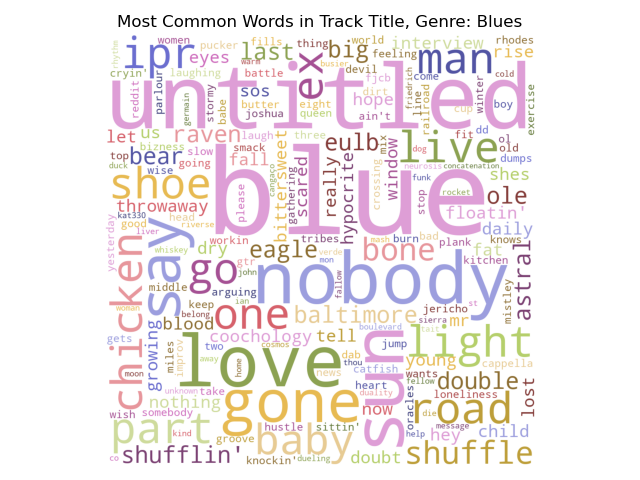

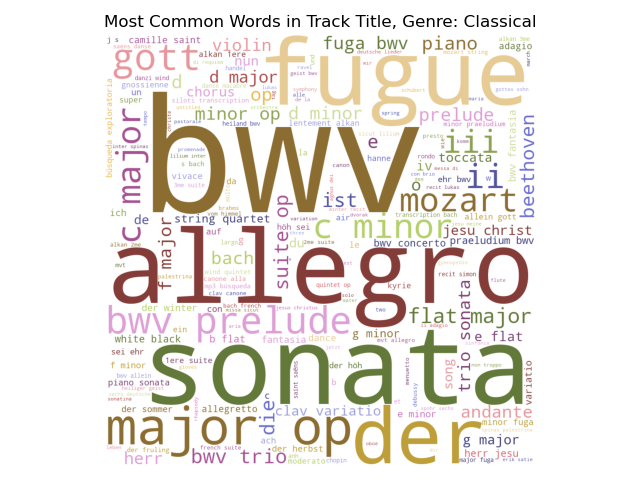

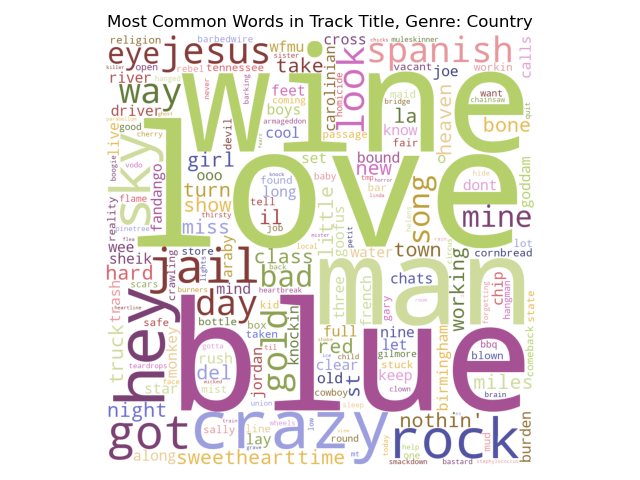

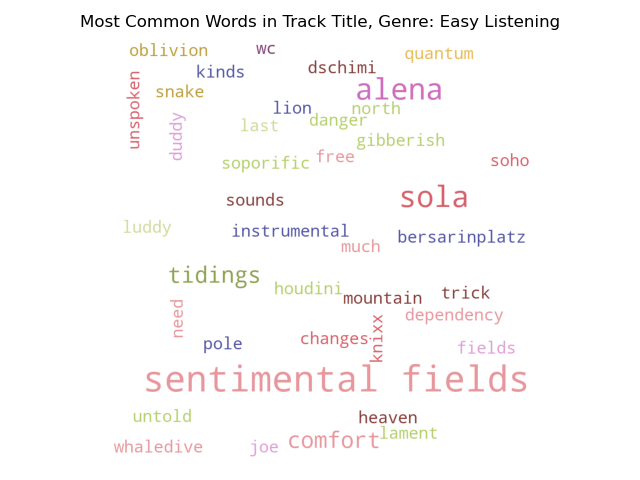

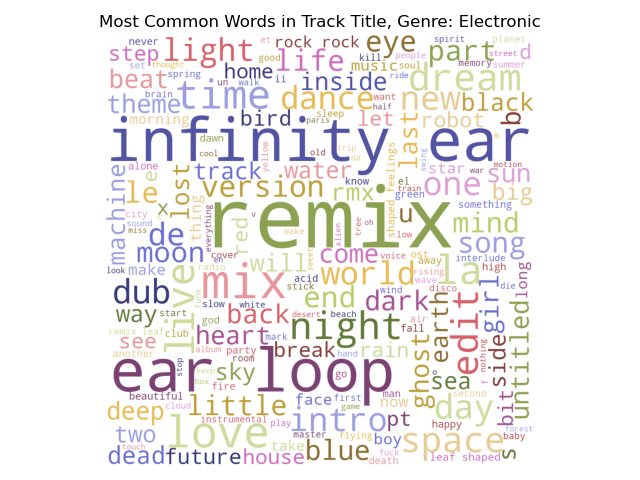

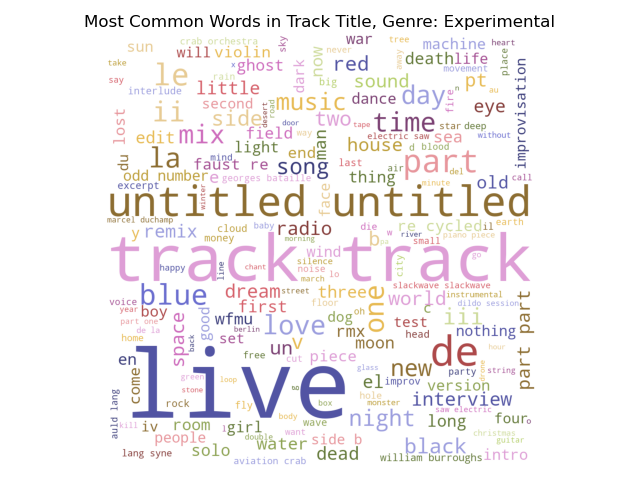

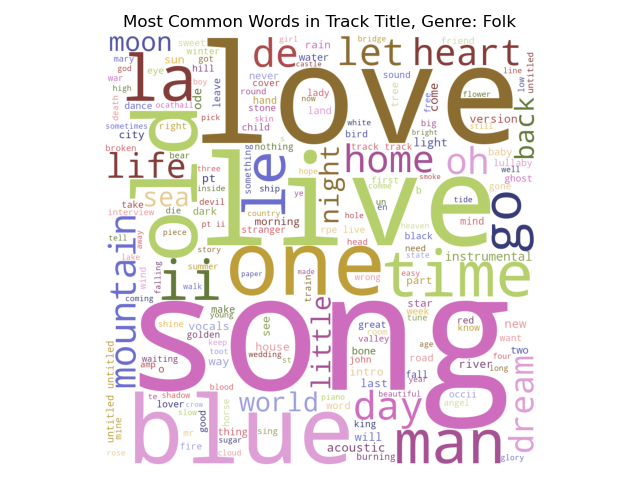

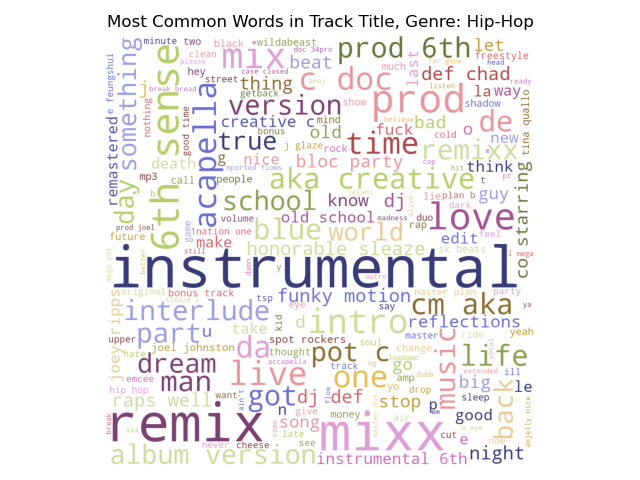

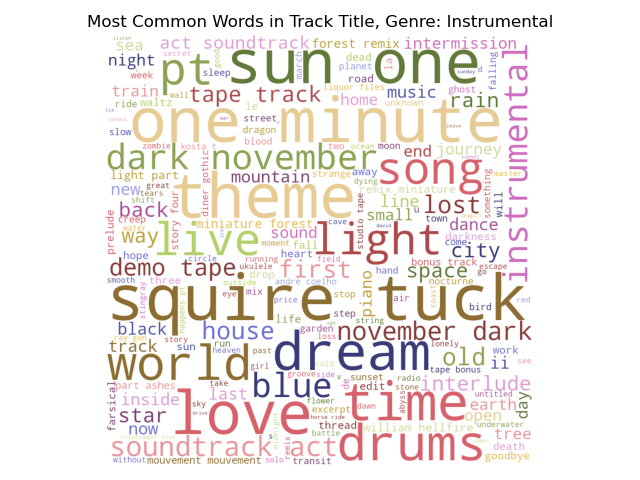

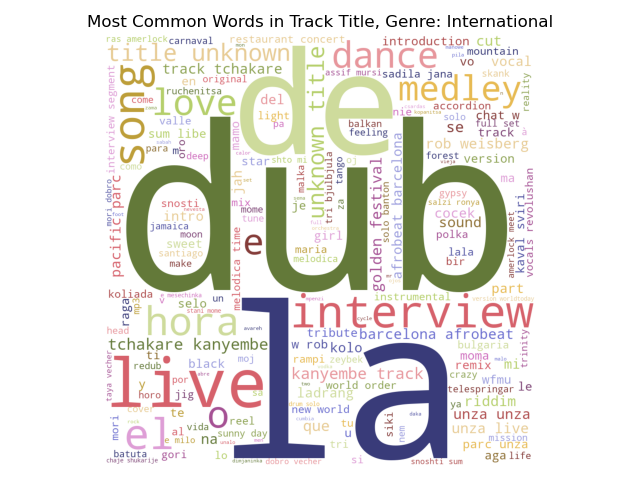

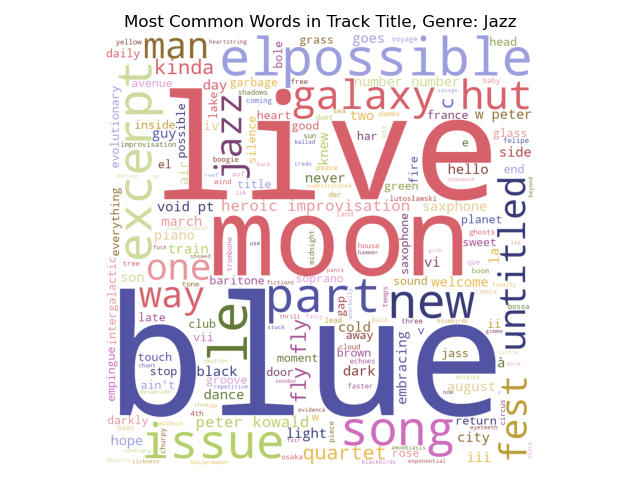

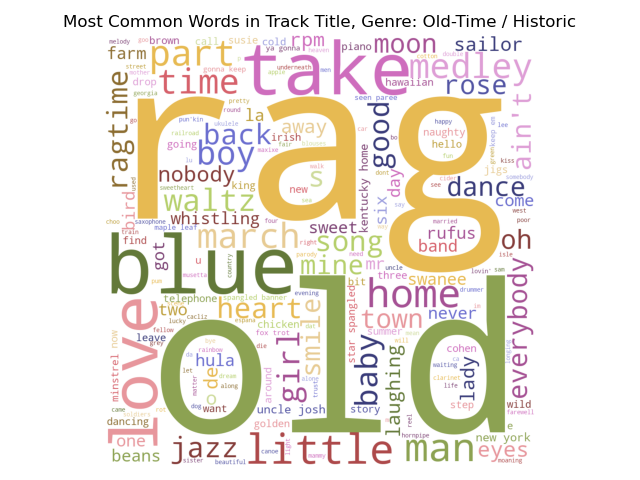

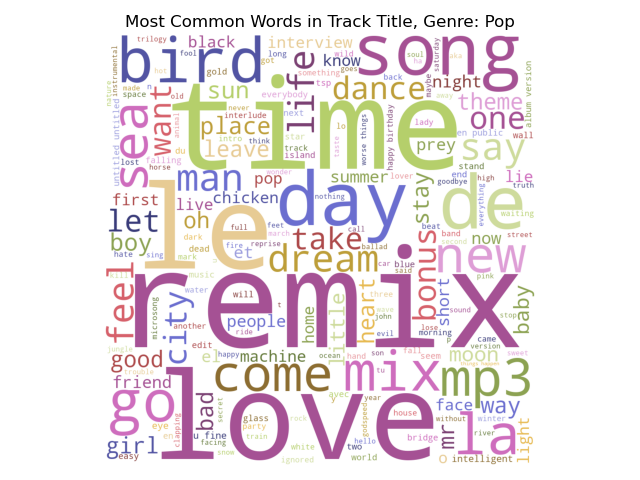

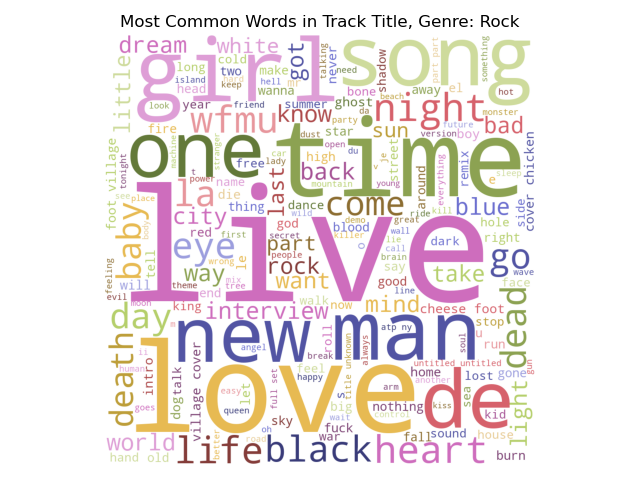

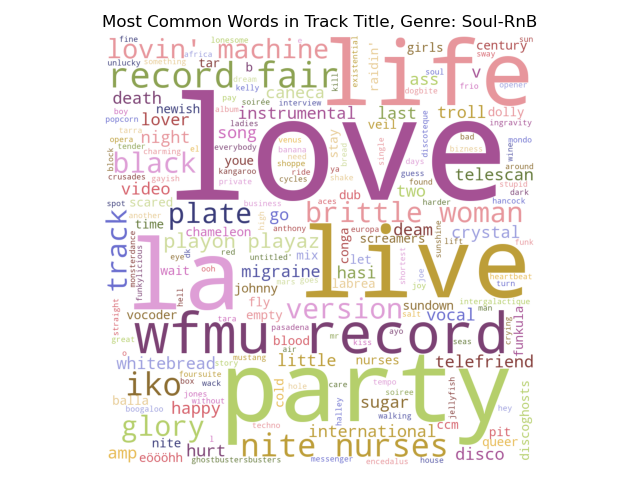

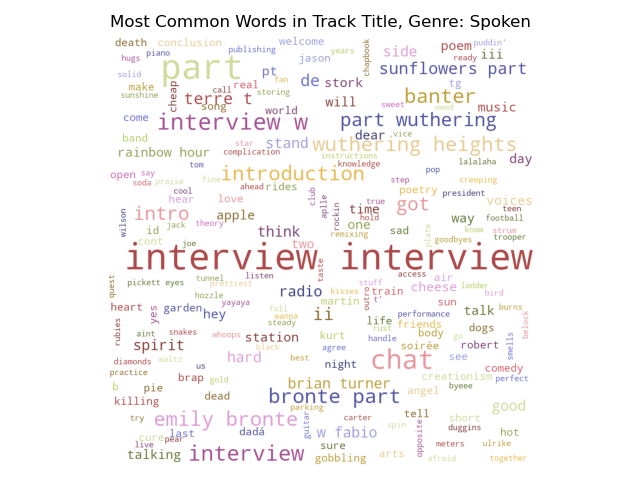

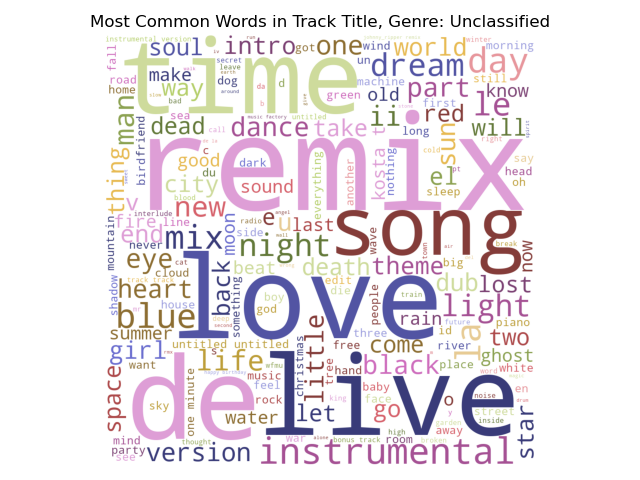

In [15]:
genre_list = list(sorted(set(track_df.track_genre_top)))

stopwords = set(STOPWORDS)
stopwords.add('feat')
stopwords.add('ft')
stopwords.add('featuring')

for genre in genre_list:
    genre_df = track_df.loc[(track_df['track_genre_top'] == genre)]

    common_words = ''

    for value in genre_df['track_title']:
        tokens = value.split()
        common_words += ' '.join(tokens)+' '

    wordcloud = WordCloud(
        width = 1000, 
        height = 1000,
        background_color ='white',
        stopwords = stopwords,
        colormap = 'tab20b',
        min_font_size = 10).generate(common_words)

    fig_genre, ax_genre = plt.subplots(layout='tight')
    plt.imshow(wordcloud)
    plt.axis("off")
    ax_genre.set_title(f'Most Common Words in Track Title, Genre: {genre}')

    plt.show()

The words de, blue, love, live, and untitled show up in many song titles. I like that untitled is somewhat meta as a title.

## 5) Visualization: Album Listens Histogram
How many listens do most albums have?

In [16]:
# Looking for 14,854 albums initially per the dataset creators.
album_listens_df = df.loc[:, ['album_date_created', 'album_id', 'album_listens']]
album_listens_df.drop_duplicates(keep='first', inplace=True)
album_listens_df.shape

(14854, 3)

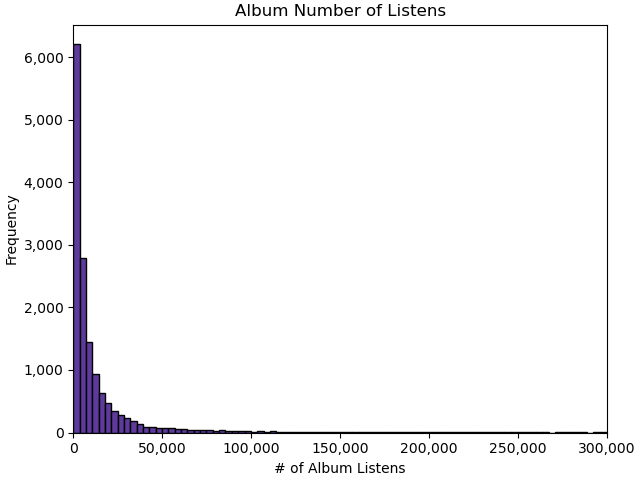

In [17]:
# Purposefully cut off view of albums with >= 300,000 listens as outliers
fig3, ax3 = plt.subplots(layout='constrained')

plt.hist(album_listens_df['album_listens'], bins=1000, color='#5D3A9B', edgecolor='#000000')
plt.title('Album Number of Listens')
ax3.set_xlabel('# of Album Listens')
ax3.set_ylabel('Frequency')
ax3.set_xlim(0, 300000)
ax3.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

Hover over the figure and use the buttons to zoom as needed. Nearly all albums have under 50,000 listens.